In [8]:
import pandas as pd
import numpy as np
import h5py
import os

In [9]:
prediction_path = '/fhgfs/users/jbehnken/make_Data/crab1314_prediction.csv'
plotting_path = '/fhgfs/users/jbehnken/make_Data/Theta_Plotting.h5'

In [7]:
keys_1 = ['event_num', 'night', 'run_id', 'theta', 'theta_deg', 'theta_deg_off_1', 'theta_deg_off_2', 'theta_deg_off_3', 'theta_deg_off_4', 'theta_deg_off_5', 'theta_off_1', 'theta_off_1_rec_pos', 'theta_off_2', 'theta_off_2_rec_pos', 'theta_off_3', 'theta_off_3_rec_pos', 'theta_off_4', 'theta_off_4_rec_pos', 'theta_off_5', 'theta_off_5_rec_pos', 'theta_rec_pos', 'unix_time_utc']
keys_2 = ['run_start', 'run_stop', 'source']

with h5py.File('/net/big-tank/POOL/projects/fact/datasets/Crab1314_darknight_std_analysis_0.17.2.hdf5', 'r') as f:
    data_1  = []
    data_2  = []
    for key in keys_1:
        data_1.append(np.array(f['events'][key]))
    for key in keys_2:
        data_2.append(np.array(f['runs'][key]))
        
data_1 = list(map(list, zip(*data_1)))
df_crab = pd.DataFrame(data_1)
df_crab.columns = keys_1
del data_1

data_2 = list(map(list, zip(*data_2)))
df_crab_runs = pd.DataFrame(data_2)
df_crab_runs.columns = keys_2
del data_2

df_crab.shape

KeyboardInterrupt: 

In [4]:
df_crab_runs.head()

,run_start,run_stop,source
0,b'2013-10-04T03:41:35.000000000',b'2013-10-04T03:46:35.000000000',Crab
1,b'2013-10-04T03:46:40.000000000',b'2013-10-04T03:51:40.000000000',Crab
2,b'2013-10-04T03:51:44.000000000',b'2013-10-04T03:56:44.000000000',Crab
3,b'2013-10-04T03:56:49.000000000',b'2013-10-04T04:01:49.000000000',Crab
4,b'2013-10-04T04:08:55.000000000',b'2013-10-04T04:13:55.000000000',Crab


In [6]:
df_pred = pd.read_csv(prediction_path)
df_pred.columns = ['night', 'run_id', 'event_num', 'proton_prediction', 'gamma_prediction']
df_pred.head(2)

,night,run_id,event_num,proton_prediction,gamma_prediction
0,20131003,187,1,0.809694,0.190306
1,20131003,187,2,0.954263,0.045737


In [7]:
df_merged = pd.merge(df_pred, df_crab, how='inner', on=['event_num', 'night', 'run_id'])
df_merged.shape

(293547, 24)

In [8]:
with h5py.File(plotting_path, 'w') as hdf:
    events = hdf.create_group('events')
    dset_gamma_prediction = events.create_dataset('gamma_prediction', data=df_merged['gamma_prediction'].values)
    dset_theta = events.create_dataset('theta', data=df_merged['theta'].values)
    dset_theta_deg_off_1 = events.create_dataset('theta_deg_off_1', data=df_merged['theta_deg_off_1'].values)
    dset_theta_deg_off_2 = events.create_dataset('theta_deg_off_2', data=df_merged['theta_deg_off_2'].values)
    dset_theta_deg_off_3 = events.create_dataset('theta_deg_off_3', data=df_merged['theta_deg_off_3'].values)
    dset_theta_deg_off_4 = events.create_dataset('theta_deg_off_4', data=df_merged['theta_deg_off_4'].values)
    dset_theta_deg_off_5 = events.create_dataset('theta_deg_off_5', data=df_merged['theta_deg_off_5'].values)
    dset_theta_deg = events.create_dataset('theta_deg', data=df_merged['theta_deg'].values)
    dset_unix_time_utc = events.create_dataset('unix_time_utc', data=df_merged['unix_time_utc'].values.tolist())
    
    runs = hdf.create_group('runs')
    dset_run_start = runs.create_dataset('run_start', data=df_crab_runs['run_start'].values.tolist())
    dset_run_stop = runs.create_dataset('run_stop', data=df_crab_runs['run_stop'].values.tolist())

In [10]:
def theta_square_plot(theta2_cut = 0.8, data_path = plotting_path, key = 'events', start = None, end = None, threshold = 0.5, bins = 40, alpha = 0.2, output = False):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import h5py
    from dateutil.parser import parse as parse_date

    from fact.io import read_h5py
    from fact.analysis import (li_ma_significance, split_on_off_source_dependent,)
    import click

    columns = [
        'gamma_prediction',
        'theta_deg',
        'theta_deg_off_1',
        'theta_deg_off_2',
        'theta_deg_off_3',
        'theta_deg_off_4',
        'theta_deg_off_5',
        'unix_time_utc',
    ]

    stats_box_template = r'''Source: {source}, $t_\mathrm{{obs}} = {t_obs:.2f}\,\mathrm{{h}}$
    $N_\mathrm{{On}} = {n_on}$, $N_\mathrm{{Off}} = {n_off}$, $\alpha = {alpha}$
    $N_\mathrm{{Exc}} = {n_excess:.1f} \pm {n_excess_err:.1f}$, $S_\mathrm{{Li&Ma}} = {significance:.1f}\,\sigma$
    '''


    theta_cut = np.sqrt(theta2_cut)

    with h5py.File(data_path, 'r') as f:
        source_dependent = 'gamma_prediction_off_1' in f[key].keys()

    if source_dependent:
        print('Separation was using source dependent features')
        columns.extend('gamma_prediction_off_' + str(i) for i in range(1, 6))
        theta_cut = np.inf
        theta2_cut = np.inf

    events = read_h5py(data_path, key='events', columns=columns)
    events['timestamp'] = pd.to_datetime(events['unix_time_utc_0'] * 1e6 + events['unix_time_utc_1'],unit='us',)
    runs = read_h5py(data_path, key='runs')
    runs['run_start'] = pd.to_datetime(runs['run_start'])
    runs['run_stop'] = pd.to_datetime(runs['run_stop'])

    if start is not None:
        events = events.query('timestamp >= @start')
        runs = runs.query('run_start >= @start')
    if end is not None:
        events = events.query('timestamp <= @end')
        runs = runs.query('run_stop <= @end')

    if source_dependent:
        on_data, off_data = split_on_off_source_dependent(events, threshold)
        theta_on = on_data.theta_deg
        theta_off = off_data.theta_deg
    else:
        selected = events.query('gamma_prediction >= {}'.format(threshold))
        theta_on = selected.theta_deg
        theta_off = pd.concat([selected['theta_deg_off_{}'.format(i)]for i in range(1, 6)])

    del events

    if source_dependent:
        limits = [0,max(np.percentile(theta_on, 99)**2, np.percentile(theta_off, 99)**2),]
    else:
        limits = [0, 0.3]

    fig = plt.figure(figsize=(5,4))
    #plt.ylim(0, 1000)
    ax = fig.add_subplot(1, 1, 1)
    h_on, bin_edges = np.histogram(theta_on.apply(lambda x: x**2).values,bins=bins,range=limits)
    h_off, bin_edges, _ = ax.hist(theta_off.apply(lambda x: x**2).values,bins=bin_edges,range=limits,weights=np.full(len(theta_off), 0.2),histtype='stepfilled',color='lightgray',)

    bin_center = bin_edges[1:] - np.diff(bin_edges) * 0.5
    bin_width = np.diff(bin_edges)

    ax.errorbar(bin_center,h_on,yerr=np.sqrt(h_on) / 2,xerr=bin_width / 2,linestyle='',label='On',)
    ax.errorbar(bin_center,h_off,yerr=alpha * np.sqrt(h_off) / 2,xerr=bin_width / 2,linestyle='',label='Off',)

    if not source_dependent:
        ax.axvline(theta_cut**2, color='gray', linestyle='--')

    n_on = np.sum(theta_on < theta_cut)
    n_off = np.sum(theta_off < theta_cut)
    significance = li_ma_significance(n_on, n_off, alpha=alpha)


    ax.text(0.5, 0.95,stats_box_template.format(source='Crab',t_obs=83.656,n_on=n_on, n_off=n_off, alpha=alpha,n_excess=n_on - alpha * n_off,n_excess_err=np.sqrt(n_on + alpha**2 * n_off),significance=significance,),transform=ax.transAxes,fontsize=12,va='top',ha='center',)

    ax.set_xlabel(r'$(\theta / {}^\circ )^2$')
    ax.legend()#(loc='lower right')
    fig.tight_layout()
    plt.xlim(0.0, 0.3)

    if output:
        fig.savefig(output, dpi=300)
    else:
        plt.show()

In [50]:
from fact.analysis import li_ma_significance
from fact.io import read_h5py

data_path=plotting_path
key='events'
start=None
end=None


columns = [
        'gamma_prediction',
        'theta_deg',
        'theta_deg_off_1',
        'theta_deg_off_2',
        'theta_deg_off_3',
        'theta_deg_off_4',
        'theta_deg_off_5',
        'unix_time_utc',
    ]

with h5py.File(data_path, 'r') as f:
    source_dependent = 'gamma_prediction_off_1' in f[key].keys()

if source_dependent:
    print('Separation was using source dependent features')
    columns.extend('gamma_prediction_off_' + str(i) for i in range(1, 6))
    theta_cut = np.inf
    theta2_cut = np.inf

events = read_h5py(data_path, key='events', columns=columns)
events['timestamp'] = pd.to_datetime(events['unix_time_utc_0'] * 1e6 + events['unix_time_utc_1'],unit='us',)
runs = read_h5py(data_path, key='runs')
runs['run_start'] = pd.to_datetime(runs['run_start'])
runs['run_stop'] = pd.to_datetime(runs['run_stop'])

if start is not None:
    events = events.query('timestamp >= @start')
    runs = runs.query('run_start >= @start')
if end is not None:
    events = events.query('timestamp <= @end')
    runs = runs.query('run_stop <= @end')



thresholds = []
for i in np.arange(0.725, 0.8, 0.001):
    for j in np.arange(0.001, 0.04, 0.001):
        threshold=i
        theta2_cut=j

        theta_cut = np.sqrt(theta2_cut)

        if source_dependent:
            on_data, off_data = split_on_off_source_dependent(events, threshold)
            theta_on = on_data.theta_deg
            theta_off = off_data.theta_deg
        else:
            selected = events.query('gamma_prediction >= {}'.format(threshold))
            theta_on = selected.theta_deg
            theta_off = pd.concat([selected['theta_deg_off_{}'.format(i)]for i in range(1, 6)])

        n_on = np.sum(theta_on < theta_cut)
        n_off = np.sum(theta_off < theta_cut)

        significance = li_ma_significance(n_on, n_off, alpha=0.2)
        thresholds.append([i, j, significance])

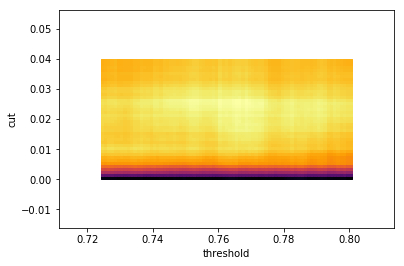

In [51]:
i, j, s = zip(*thresholds)

plt.scatter(x=i, y=j, c=s, cmap='inferno', marker='s')
plt.xlabel('threshold')
plt.ylabel('cut')
plt.show()

In [52]:
import matplotlib.pyplot as plt
for elem in thresholds:
    if elem[2]==max(s):
        print(elem)
print(max(s))

[0.76600000000000001, 0.026000000000000002, 24.399341390006484]
24.39934139


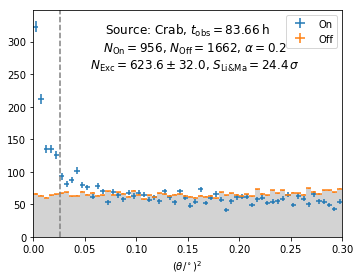

In [11]:
theta_square_plot(theta2_cut=0.026, data_path=plotting_path, key='events', start=None, end=None, threshold=0.766, bins=60, alpha=0.2, output=False)

In [1]:
import h5py
import numpy as np
import pandas as pd

In [2]:
path = '/fhgfs/users/jbehnken/make_Data/Crab1314_darknight_std_analysis_0.17.2.hdf5'
prediction_path = '/fhgfs/users/jbehnken/make_Data/crab1314_prediction.csv'

with h5py.File(path, 'r') as f:
    night = np.array(f['runs']['night'])
    run_id = np.array(f['runs']['run_id'])
    ontime = np.array(f['runs']['ontime'])

In [3]:
df = pd.read_csv(prediction_path)
df = df[['Night', 'Run']]
df = df.drop_duplicates()

theta_df = pd.DataFrame(list(zip(night, run_id, ontime)), columns=['Night', 'Run', 'Ontime'])

merge_df = df.merge(theta_df)
merge_df['Ontime'].sum()/3600

83.65641758333334